In [240]:
# Cell 2 - imports and load data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

PATH_CSV     = "aggregated_data\weekly_features.csv"

df = pd.read_csv(PATH_CSV, parse_dates=["Date"])
print("Loaded", PATH_CSV)

# Basic checks
DATE_COL = "Date"
TARGET_COL = "total_sales"
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

print("Observations:", len(df))
display(df.head(3))


Loaded aggregated_data\weekly_features.csv
Observations: 65


<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:11: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11660\4169955692.py:11: SyntaxWarning: invalid escape sequence '\w'
  PATH_CSV     = "aggregated_data\weekly_features.csv"


,Date,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,...,avg_qty_per_order,unique_customers,orders_per_customer,returning_times_session,discountrate_times_qty,category_share_Electronics,category_share_Home & Garden,category_share_Sports,category_share_Fashion,category_share_Toys
0,2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,...,2.880597,67,1.000000,8.375139,1.203832,0.519320,0.190078,0.066568,0.090124,0.045320
1,2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,...,3.003937,252,1.007937,8.734252,1.123520,0.419759,0.197702,0.197547,0.058083,0.042290
2,2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,...,2.929104,259,1.034749,9.258075,1.180385,0.365671,0.182891,0.203321,0.116558,0.049825


In [241]:
# Cell 3 - configuration and selected features

MIN_HISTORY = 6   # minimum weeks of history required to train/predict
MA_WINDOW = 4     # used only for moving-average fallback or comparison

# conservative initial feature set (adapt if some columns missing)
preferred_features = [
    "week_idx",
    "total_sales_lag_1", "total_sales_lag_2", "total_sales_lag_4",
    "total_sales_rollmean_3", "total_sales_rollmean_4", "total_sales_rollstd_3",
    "total_quantity_lag_1",
    "avg_session_duration_lag_1", "avg_pages_viewed_lag_1", "pct_returning_lag_1",
    "avg_qty_per_order"
]



# keep only features that actually exist in df
features = [f for f in preferred_features if f in df.columns]
print("Using features:", features)


Using features: ['week_idx', 'total_sales_lag_1', 'total_sales_lag_2', 'total_sales_lag_4', 'total_sales_rollmean_3', 'total_sales_rollmean_4', 'total_sales_rollstd_3', 'total_quantity_lag_1', 'avg_session_duration_lag_1', 'avg_pages_viewed_lag_1', 'pct_returning_lag_1', 'avg_qty_per_order']


In [242]:
# Cell 4 - evaluation metrics

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_robust(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def me(y_true, y_pred):
    return float(np.mean(np.array(y_pred) - np.array(y_true)))


In [243]:
# Cell 5 - XGBoost conservative parameters

xgb_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.02,
    "max_depth": 3,            # shallow to avoid overfitting
    "n_estimators": 180,       # number of boosting rounds
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.9,          # L1
    "reg_lambda": 1.8,         # L2
    "random_state": 42,
    "verbosity": 0,
    "n_jobs": 1
}


In [244]:
# Cell 6 - XGBoost walk-forward training & prediction
# Requires: df, features, DATE_COL, TARGET_COL, MIN_HISTORY, MA_WINDOW, xgb_params defined

dates = df[DATE_COL].values
y = df[TARGET_COL].values
T = len(df)

pred_rows_xgb = []
feat_importance_accum_xgb = {f: 0.0 for f in features}

t0 = time.time()
fit_times = []

for t in range(MIN_HISTORY, T):
    train_idx = np.arange(0, t)
    test_idx  = t

    X_train = df.loc[train_idx, features].copy()
    y_train = df.loc[train_idx, TARGET_COL].copy()
    X_test  = df.loc[test_idx, features].copy()   # series

    # Drop rows with missing features
    non_na_train_mask = X_train.notna().all(axis=1)
    X_train = X_train.loc[non_na_train_mask]
    y_train = y_train.loc[non_na_train_mask]

    # Require minimum history
    if len(X_train) < MIN_HISTORY:
        # skip this step (or optionally fallback); consistent with LightGBM notebook you used continue
        continue

    # If test features contain NaN, fallback to moving-average
    if X_test.isna().any():
        xgb_pred = float(np.mean(y[train_idx][-MA_WINDOW:]))
        used = "fallback_ma"
        pred_rows_xgb.append({
            "Date": dates[test_idx],
            "actual": float(y[test_idx]),
            "xgb_pred": xgb_pred,
            "train_n": len(X_train),
            "status": used
        })
        continue

    # Fit XGB regressor
    start = time.time()
    try:
        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train, verbose=False)
        fit_time = time.time() - start
        fit_times.append(fit_time)

        # predict
        xgb_pred = float(model.predict(X_test.values.reshape(1, -1))[0])
        used = "trained"

        # accumulate gain-based feature importance from booster
        booster = model.get_booster()
        # get_score returns dict: {feature_name: gain}
        # feature names should be the column names; ensure mapping exists
        try:
            gain_dict = booster.get_score(importance_type="gain")
        except Exception:
            gain_dict = {}  # fallback

        # XGBoost keys sometimes are column names (preferred) or 'f0','f1' etc.
        # If keys are numeric labels like f0, convert via mapping
        # We'll try to map column indices to names if needed
        # If gain_dict keys are column names, use them directly
        keys = list(gain_dict.keys())
        if keys and keys[0].startswith("f") and keys[0][1:].isdigit():
            # map 'f0' -> features[int(0)]
            for k, v in gain_dict.items():
                idx = int(k[1:])
                if idx < len(features):
                    feat_importance_accum_xgb[features[idx]] += v
        else:
            # keys are expected to be actual feature names
            for fname, gain in gain_dict.items():
                if fname in feat_importance_accum_xgb:
                    feat_importance_accum_xgb[fname] += gain
                else:
                    # sometimes XGBoost stores feature name with different encoding; ignore otherwise
                    pass

    except Exception as e:
        xgb_pred = float(y[train_idx[-1]])
        used = f"fallback_error:{str(e)[:80]}"

    pred_rows_xgb.append({
        "Date": dates[test_idx],
        "actual": float(y[test_idx]),
        "xgb_pred": xgb_pred,
        "train_n": len(X_train),
        "status": used
    })

t_elapsed = time.time() - t0
print(f"XGBoost walk-forward completed in {t_elapsed:.1f}s; avg fit time (trained steps) ~ {np.mean(fit_times):.2f}s")


XGBoost walk-forward completed in 1.0s; avg fit time (trained steps) ~ 0.02s


In [245]:
# Cell D - results DataFrame and evaluation metrics for XGBoost

results_xgb = pd.DataFrame(pred_rows_xgb)

mask_valid = results_xgb["xgb_pred"].notna()
y_true_xgb = results_xgb.loc[mask_valid, "actual"].values
y_pred_xgb = results_xgb.loc[mask_valid, "xgb_pred"].values

metrics_xgb = {
    "RMSE": rmse(y_true_xgb, y_pred_xgb),
    "MAPE(%)": mape_robust(y_true_xgb, y_pred_xgb),
    "ME": me(y_true_xgb, y_pred_xgb),
    "N_preds": len(y_pred_xgb)
}
print("XGBoost walk-forward metrics:")
for k,v in metrics_xgb.items():
    print(f"  {k}: {v}")

results_xgb.head()


XGBoost walk-forward metrics:
  RMSE: 42354.73926376068
  MAPE(%): 9.776505678562595
  ME: -2349.1679999999988
  N_preds: 55


,Date,actual,xgb_pred,train_n,status
0,2023-03-13,323682.07,335834.62500,6,trained
1,2023-03-20,313631.01,330782.46875,7,trained
2,2023-03-27,390888.82,329436.28125,8,trained
3,2023-04-03,320561.13,326837.75000,9,trained
4,2023-04-10,318879.66,334768.06250,10,trained


In [246]:
# Cell E - moving-average baseline for same XGBoost evaluation points

ma_preds = []
for i, row in results_xgb.iterrows():
    date = row["Date"]
    idx = df.index[df[DATE_COL] == date][0]
    if idx >= MA_WINDOW:
        ma_pred = float(np.mean(df.loc[idx-MA_WINDOW:idx-1, TARGET_COL].values))
    else:
        ma_pred = float(df.loc[:idx-1, TARGET_COL].iloc[-1])
    ma_preds.append(ma_pred)

results_xgb["moving_avg"] = ma_preds

y_pred_ma_xgb = results_xgb["xgb_pred"].values
metrics_ma_xgb = {"RMSE": rmse(y_true_xgb, y_pred_ma_xgb), "MAPE(%)": mape_robust(y_true_xgb, y_pred_ma_xgb), "ME": me(y_true_xgb, y_pred_ma_xgb)}
print("Moving-average metrics on same evaluation points (XGBoost eval set):")
for k,v in metrics_ma_xgb.items():
    print(f"  {k}: {v}")


Moving-average metrics on same evaluation points (XGBoost eval set):
  RMSE: 42354.73926376068
  MAPE(%): 9.776505678562595
  ME: -2349.1679999999988


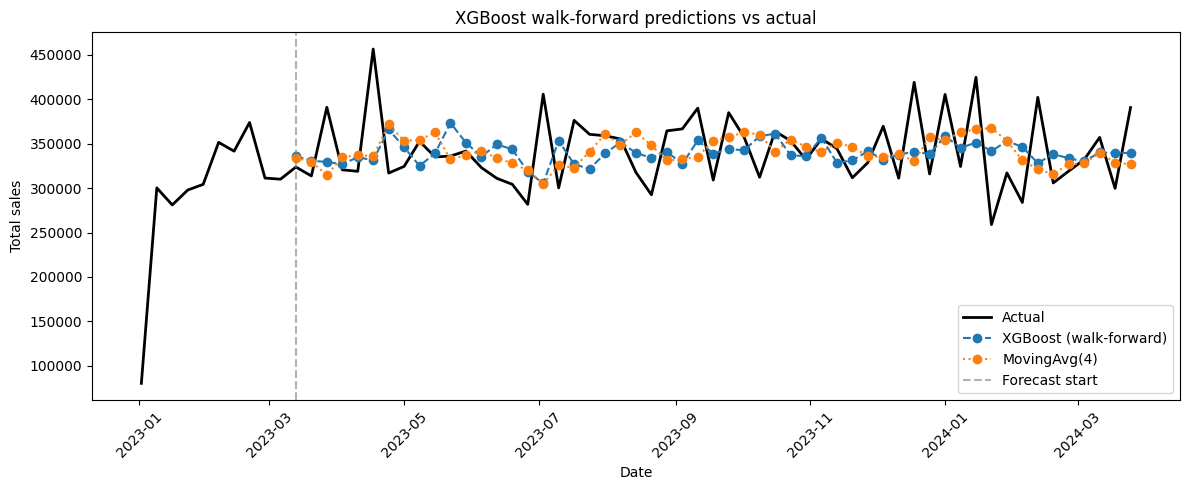

In [247]:
# Cell F - visualization for XGBoost
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL], df[TARGET_COL], label="Actual", color="black", linewidth=2)
plt.plot(results_xgb["Date"], results_xgb["xgb_pred"], label="XGBoost (walk-forward)", marker="o", linestyle="--")
plt.plot(results_xgb["Date"], results_xgb["moving_avg"], label=f"MovingAvg({MA_WINDOW})", marker="o", linestyle=":")
if len(results_xgb)>0:
    plt.axvline(results_xgb["Date"].iloc[0], color="grey", linestyle="--", alpha=0.6, label="Forecast start")
plt.xlabel("Date")
plt.ylabel("Total sales")
plt.title("XGBoost walk-forward predictions vs actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [248]:
# Cell G - aggregated feature importances for XGBoost

n_trained_steps_xgb = sum(1 for r in pred_rows_xgb if r["status"] == "trained")
fi_df_xgb = pd.DataFrame({
    "feature": list(feat_importance_accum_xgb.keys()),
    "gain_sum": list(feat_importance_accum_xgb.values())
}).sort_values("gain_sum", ascending=False)

if n_trained_steps_xgb > 0:
    fi_df_xgb["gain_avg"] = fi_df_xgb["gain_sum"] / n_trained_steps_xgb
else:
    fi_df_xgb["gain_avg"] = 0.0

display(fi_df_xgb.head(20))


,feature,gain_sum,gain_avg
11,avg_qty_per_order,9.571294e+10,1.740235e+09
3,total_sales_lag_4,6.842112e+10,1.244020e+09
6,total_sales_rollstd_3,6.650670e+10,1.209213e+09
5,total_sales_rollmean_4,5.726143e+10,1.041117e+09
1,total_sales_lag_1,5.649038e+10,1.027098e+09
8,avg_session_duration_lag_1,5.238277e+10,9.524141e+08
2,total_sales_lag_2,4.875267e+10,8.864122e+08
9,avg_pages_viewed_lag_1,4.825570e+10,8.773764e+08
4,total_sales_rollmean_3,4.763289e+10,8.660526e+08
10,pct_returning_lag_1,4.460868e+10,8.110669e+08


In [249]:
# Cell H - save XGBoost results and importances
results_xgb.to_csv("xgb_walk_forward_predictions.csv", index=False)
fi_df_xgb.to_csv("xgb_feature_importance.csv", index=False)
print("Saved xgb_walk_forward_predictions.csv and xgb_feature_importance.csv")


Saved xgb_walk_forward_predictions.csv and xgb_feature_importance.csv


In [250]:
# Cell I - top features by gain (XGBoost) and split count if available

# Get final trained booster (if at least one trained model exists)
# Note: model variable exists only in last trained step; else you can omit per-tree split counts
try:
    final_model = model  # last model variable from loop
    booster_final = final_model.get_booster()
    importance_dict = booster_final.get_score(importance_type='gain')
    # convert dict -> DataFrame
    imp_list = []
    for k,v in importance_dict.items():
        imp_list.append((k, v))
    imp_df = pd.DataFrame(imp_list, columns=["feature","gain"]).sort_values("gain", ascending=False)
    display(imp_df.head(20))
except Exception as e:
    print("No final booster available for per-model importance display:", e)
    display(fi_df_xgb.head(20))


,feature,gain
11,avg_qty_per_order,2.749685e+09
6,total_sales_rollstd_3,2.386505e+09
1,total_sales_lag_1,2.291178e+09
8,avg_session_duration_lag_1,2.013626e+09
3,total_sales_lag_4,1.986840e+09
10,pct_returning_lag_1,1.863512e+09
2,total_sales_lag_2,1.789277e+09
7,total_quantity_lag_1,1.609519e+09
9,avg_pages_viewed_lag_1,1.404948e+09
5,total_sales_rollmean_4,1.376991e+09


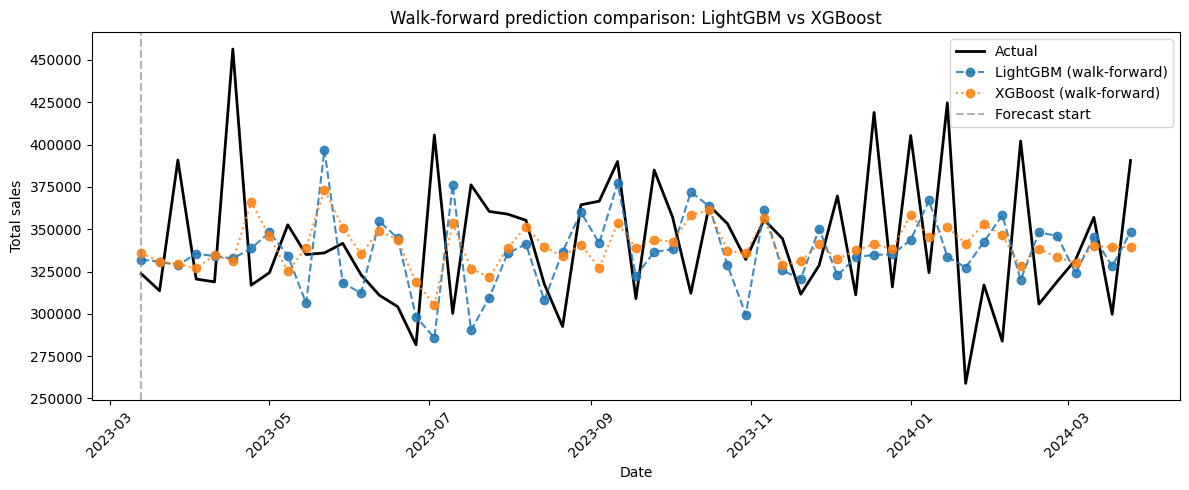

In [251]:
# Cell — Compare LightGBM vs XGBoost predictions (walk-forward)

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Load predictions
# ------------------------------------------------------------------
lgb_path = "lgb_walk_forward_predictions.csv"
xgb_path = "xgb_walk_forward_predictions.csv"

lgb_df = pd.read_csv(lgb_path, parse_dates=["Date"])
xgb_df = pd.read_csv(xgb_path, parse_dates=["Date"])

# Keep only necessary columns and rename to avoid collision
lgb_df = lgb_df[["Date", "actual", "lgb_pred"]]
xgb_df = xgb_df[["Date", "xgb_pred"]]

# Merge on Date (inner join ensures same evaluation points)
cmp_df = pd.merge(lgb_df, xgb_df, on="Date", how="inner")

# ------------------------------------------------------------------
# Visualization
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Ground truth
plt.plot(
    cmp_df["Date"],
    cmp_df["actual"],
    label="Actual",
    color="black",
    linewidth=2
)

# LightGBM predictions
plt.plot(
    cmp_df["Date"],
    cmp_df["lgb_pred"],
    label="LightGBM (walk-forward)",
    marker="o",
    linestyle="--",
    alpha=0.85
)

# XGBoost predictions
plt.plot(
    cmp_df["Date"],
    cmp_df["xgb_pred"],
    label="XGBoost (walk-forward)",
    marker="o",
    linestyle=":",
    alpha=0.85
)

# Forecast start marker
plt.axvline(
    cmp_df["Date"].iloc[0],
    color="grey",
    linestyle="--",
    alpha=0.6,
    label="Forecast start"
)

plt.xlabel("Date")
plt.ylabel("Total sales")
plt.title("Walk-forward prediction comparison: LightGBM vs XGBoost")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
